In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from screed.fastq import fastq_iter
import gzip

## First try: will it map?

 - Run `normalize-by-median.py` with cutoff = 1 on the reference
   * No need to do this.
   * Actually cutoff was the trusted parameter on the aligner...
 - Load the reference into counting table
 - Used as much memory I had available on the node I was running it (~28G)
 - I modified `find-variant-by-align-long.py` to only output the header of each alignment.
 - The ecoli example load reads into counting table and then maps the reference to it. I started through the same route with PacBio, but it required too much memory (I'll try again on HPCC). From the email I understood I should load the reference and then map the reads, but a part of the reference is discarded during diginorm.
 - There are many 'N' and soft-clipped sequences in the reference. Is this an issue?
   * Yes, it is. Replaced all 'N' with 'A' on a new file, 'galGal4.fixed.fa.gz'

### Commands for just loading the reference (no diginorm), replaced 'N' with 'A'

In [39]:
!cd ../2015-khmer-wok2-vc && make -Bn galGal4.fixed.align.out

wget -SNc ftp://hgdownload.cse.ucsc.edu/goldenPath/galGal4/bigZips/galGal4.fa.gz
python fix_reference.py galGal4.fa.gz galGal4.fixed.fa.gz
load-into-counting.py -k 21 -x 7e9 galGal4.fixed.k21.kh galGal4.fixed.fa.gz
../2015-experimental-graphalign/find-variant-by-align-long.py --trusted 1 galGal4.fixed.k21.kh /home/chick/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-1_LongRead.fastq.gz --variants-out variants-galGal4-fixed.txt > galGal4.fixed.align.out


In [40]:
!ls -sh ../2015-khmer-wok2-vc/galGal4.fixed.k21.kh
!cat ../2015-khmer-wok2-vc/galGal4.fixed.k21.kh.info

27G ../2015-khmer-wok2-vc/galGal4.fixed.k21.kh
through galGal4.fixed.fa.gz
fp rate estimated to be 0.000



### Check alignment quality

 - It's attrocious. Not really, I was just running it wrong. Using `--trusted 1` alignments are actually very good!

In [20]:
def check_align(align_out, ranges=[(0, 10), (0, 1, .1)]):
    reads = {}

    with open(align_out, 'r') as f:
        for line in f:
            if '%' in line:
                name, start, end, span, percent = line.strip().split()
                reads[name] = {'start': int(start), 'end': int(end), 'span': int(span), 'percent': float(percent[:-1])}

    data = pd.DataFrame.from_dict(reads).T
    
    plt.figure()
    plt.title("Almost all the reads on range ({0}-{1}%)".format(*ranges[0]))
    plt.xlabel("% of the read aligned to reference")
    plt.ylabel("Number of reads")
    data['percent'].hist()
    data['percent'].hist(bins=np.arange(*ranges[0]))

    plt.figure()
    plt.title("Actually, on range ({0}-{1}%)".format(*ranges[1]))
    plt.xlabel("% of the read aligned to reference")
    plt.ylabel("Number of reads")
    data['percent'].hist(bins=np.arange(*ranges[0]))
    data['percent'].hist(bins=np.arange(*ranges[1]))
    
    return data

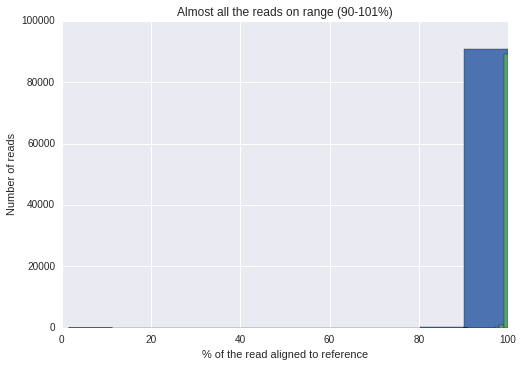

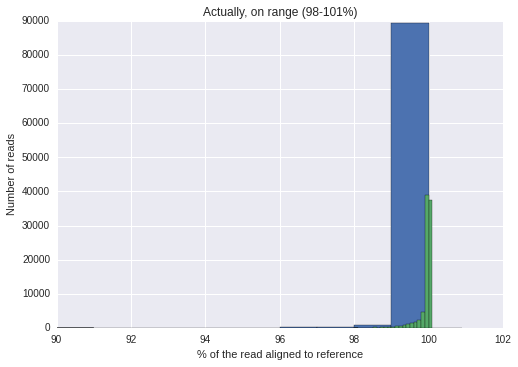

In [35]:
data = check_align('../2015-khmer-wok2-vc/galGal4.fixed.align.out', ranges=[(90, 101), (98, 101, .1)])

### Bonus: I broke the readaligner!

`find-variant-by-align-long.py` segfaulted, memory consumption slowly but steadily increases (about half the moleculo reads were processed for the previous figures).

## Loading reads and aligning the reference to it

 - Used QP's functions to find the approximate memory needed (after counting unique kmers with HLL).
   * Estimated unique kmers: 904.369.109
   * Expected error rate: 0.01
   * Calculated parameters:
     - Number of tables: 6
     - Memory per table: 2e9
 - Tested with `--trusted 5`
 - There are ~15k contigs in galGal4, more than 10k align >90%
 - <span style="color:red">Needs attention</span>: I was considering 'percent' for check if it was working, but it means something different than I expected: "percent matched" means "percent of the span matched", where span doesn't imply start to end of read.

In [22]:
!cd ../2015-khmer-wok2-vc && make -Bn moleculo.align.out

load-into-counting.py -k 21 -N 6 -x 2e9 moleculo.k21.kh /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-1_LongRead_500_1499nt.fastq.gz /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-1_LongRead.fastq.gz /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-2_LongRead_500_1499nt.fastq.gz /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-2_LongRead.fastq.gz /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-3_LongRead_500_1499nt.fastq.gz /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-3_LongRead.fastq.gz /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-4_LongRead_500_1499nt.fastq.gz /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-4_LongRead.fastq.gz /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-5_

In [38]:
!ls -sh ../2015-khmer-wok2-vc/moleculo.k21.kh
!cat ../2015-khmer-wok2-vc/moleculo.k21.kh.info

7.7G ../2015-khmer-wok2-vc/moleculo.k21.kh
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-1_LongRead_500_1499nt.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-1_LongRead.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-2_LongRead_500_1499nt.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-2_LongRead.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-3_LongRead_500_1499nt.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-3_LongRead.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-4_LongRead_500_1499nt.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-4_LongRead.fastq.gz
through /mnt/research/ged/irberlu

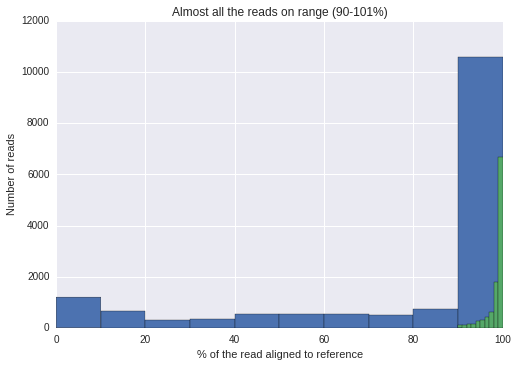

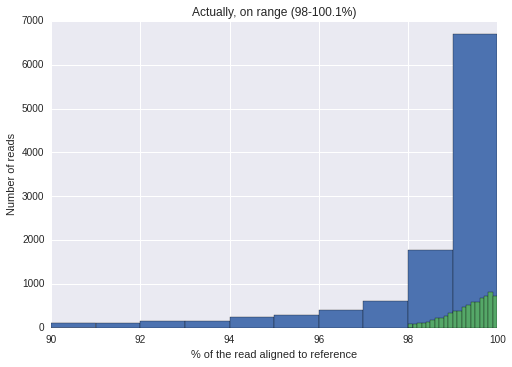

In [40]:
data = check_align('../2015-khmer-wok2-vc/moleculo.align.out', ranges=[(90, 101), (98, 100.1, .1)])

In [41]:
data[data['percent'] > 90].count()

end        10604
percent    10604
span       10604
start      10604
dtype: int64

In [43]:
data.sort('span', ascending=False).head(20)

,end,percent,span,start
chr1,195284953,86.874,25632877,169652076
chrZ,82367875,71.042,23851812,58516063
chr2,148816091,87.133,19147781,129668310
chr3,110451292,86.989,14370922,96080370
chr4,90219931,85.835,12779290,77440641
chr5,59582583,84.961,8960409,50622174
chr7,36246061,85.985,5079957,31166104
chr6,34952711,85.929,4918052,30034659
chr8,28768056,84.042,4590887,24177169
chr9,23442432,84.404,3656106,19786326


## Training

 - K=21
 - Reference: galGal4
 - Query: galGal4.LR6000017-DNA_A01-LRAAA-AllReads.sorted.bam (previously mapped with bwa-mem)

### Problems

 - galGal4 has 'N' and soft-clipped regions. Training script not ready for this in CIGAR:
   ```python
   >>> cigar_to_state
   {0: 'M', 1: 'Ir', 2: 'Ig'}
   >>> rec.cigarstring
   '251S638M1I16M'
   ```
   Does it make sense to support other fields, or should I clean up the reference first? (From http://davetang.org/wiki/tiki-index.php?page=SAM )

| op | Description                                                    |
|----|----------------------------------------------------------------|
| M	 | Alignment match (can be a sequence match or mismatch           |
| I	 | Insertion to the reference                                     |
| D	 | Deletion from the reference                                    |
| N	 | Skipped region from the reference                              |
| S	 | Soft clip on the read (clipped sequence present in <seq>)      |
| H	 | Hard clip on the read (clipped sequence NOT present in <seq>)  |
| P	 | Padding (silent deletion from the padded reference sequence)   |

